In [8]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load dataset
data_url_1 = "https://gist.githubusercontent.com/mbonsma/8da0990b71ba9a09f7de395574e54df1/raw/aec88b30af87fad8d45da7e774223f91dad09e88/lh_data.csv"
data_url_2 = "https://gist.githubusercontent.com/mbonsma/2f4076aab6820ca1807f4e29f75f18ec/raw/62f3ec07514c7e31f5979beeca86f19991540796/cdc_vs00199_table310.tsv"
lefthanded_data = pd.read_csv(data_url_1)
death_distribution_data = pd.read_csv(data_url_2, sep = '\t', skiprows=[1])

In [9]:
# Explore data
lefthanded_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     77 non-null     int64  
 1   Male    77 non-null     float64
 2   Female  77 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.9 KB


In [10]:
lefthanded_data.head()

,Age,Male,Female
0,10,12.717558,12.198041
1,11,15.318830,11.144804
2,12,14.808281,11.549240
3,13,13.793744,11.276442
4,14,15.156304,11.572906


Text(0, 0.5, 'Left-handedness rate')

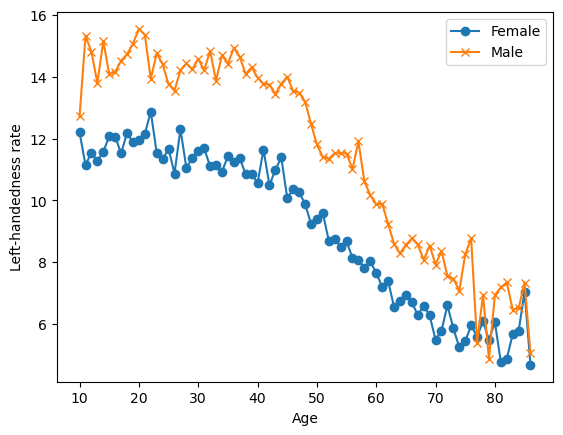

In [4]:
# plot male and female left-handedness rates vs. age
%matplotlib inline
fig, ax = plt.subplots()
ax.plot('Age', 'Female', data=lefthanded_data, marker = 'o') 
ax.plot('Age', 'Male', data=lefthanded_data, marker = 'x') 
ax.legend()
ax.set_xlabel('Age')
ax.set_ylabel('Left-handedness rate')

In [11]:
death_distribution_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         125 non-null    int64  
 1   Both Sexes  120 non-null    float64
 2   Male        115 non-null    float64
 3   Female      120 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 4.0 KB


Text(0, 0.5, 'Mean left-handedness rate')

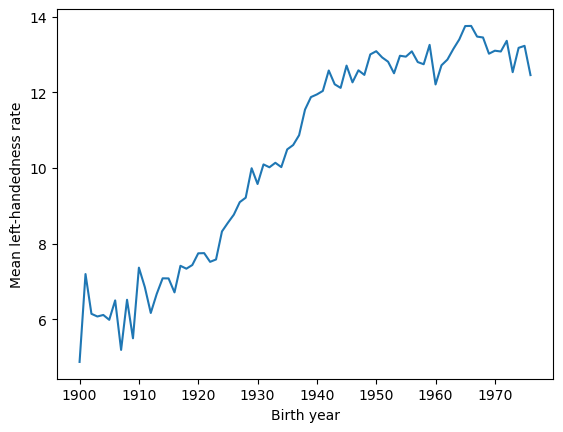

In [24]:
# create a new column for birth year of each age
lefthanded_data['Birth_year'] = 1986 - lefthanded_data['Age']

# create a new column for the average of male and female
lefthanded_data['Mean_lh'] = lefthanded_data[['Male', 'Female']].mean(axis=1)

# create a plot of the 'Mean_lh' column vs. 'Birth_year'
fig, ax = plt.subplots()
ax.plot('Birth_year','Mean_lh', data=lefthanded_data) 
ax.set_xlabel('Birth year') 
ax.set_ylabel('Mean left-handedness rate')

In [25]:
death_distribution_data.head()

,Age,Both Sexes,Male,Female
0,0,27937.0,15646.0,12291.0
1,1,1989.0,1103.0,886.0
2,2,1376.0,797.0,579.0
3,3,1046.0,601.0,445.0
4,4,838.0,474.0,364.0


In [29]:
# create a function for P(LH | A) - probability that you are left-handed given that you died at age A
def P_lh_given_A(ages_of_death, study_year = 1990):
    """ P(Left-handed | ages of death), calculated based on the reported rates of left-handedness.
    Inputs: numpy array of ages of death, study_year
    Returns: probability of left-handedness given that subjects died in `study_year` at ages `ages_of_death` """
    
    # Use the mean of the 10 last and 10 first points for left-handedness rates before and after the start 
    early_1900s_rate = lefthanded_data['Mean_lh'][-10:].mean()
    late_1900s_rate = lefthanded_data['Mean_lh'][:10].mean()
    middle_rates = lefthanded_data.loc[lefthanded_data['Birth_year'].isin(study_year - ages_of_death)]['Mean_lh']
    youngest_age = study_year - 1986 + 10 # the youngest age is 10
    oldest_age = study_year - 1986 + 86 # the oldest age is 86
    
    P_return = np.zeros(ages_of_death.shape) 
    P_return[ages_of_death > oldest_age] = early_1900s_rate / 100
    P_return[ages_of_death < youngest_age] = late_1900s_rate / 100
    P_return[np.logical_and((ages_of_death <= oldest_age), (ages_of_death >= youngest_age))] = middle_rates / 100
    
    return P_return

Text(0, 0.5, 'Number of deaths')

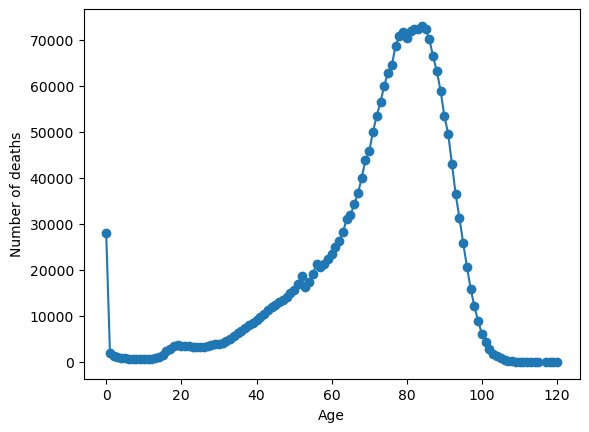

In [30]:
# Estimate the probability of living to an age A

# drop NaN values from the `Both Sexes` column in the death_distribution_data dataframe
death_distribution_data = death_distribution_data.dropna(subset=['Both Sexes'])

# plot number of people who died as a function of age
fig, ax = plt.subplots()
ax.plot('Age', 'Both Sexes', data=death_distribution_data, marker='o') # plot 'Both Sexes' vs. 'Age'
ax.set_xlabel('Age')
ax.set_ylabel('Number of deaths')

In [31]:
# Calculate a function for P(LH) - overall probability of left-handedness
def P_lh(death_distribution_data, study_year = 1990): # sum over P_lh for each age group
    """ Overall probability of being left-handed if you died in the study year
    Input: dataframe of death distribution data, study year
    Output: P(LH), a single floating point number """
    p_list = death_distribution_data['Both Sexes']*P_lh_given_A(death_distribution_data['Age'], study_year) # multiply number of dead people by P_lh_given_A
    p = np.sum(p_list) # calculate the sum of p_list
    return p/np.sum(death_distribution_data['Both Sexes']) # normalize to total number of people (sum of death_distribution_data['Both Sexes'])

print(P_lh(death_distribution_data))

0.07766387615350638


In [32]:
# Combine measures using Bayes' theorem to get get P(A | LH), the probability of being age A at death (in the study year) given that you're left-handed
def P_A_given_lh(ages_of_death, death_distribution_data, study_year = 1990):
    """ The overall probability of being a particular `age_of_death` given that you're left-handed """
    P_A = death_distribution_data['Both Sexes'][ages_of_death] / np.sum(death_distribution_data['Both Sexes'])
    P_left = P_lh(death_distribution_data, study_year) 
    P_lh_A = P_lh_given_A(ages_of_death, study_year) 
    return P_lh_A*P_A/P_left

In [33]:
# Create the same function to compare results with P(A | RH), the probability of being age A at death given that you're right-handed
def P_A_given_rh(ages_of_death, death_distribution_data, study_year = 1990):
    """ The overall probability of being a particular `age_of_death` given that you're right-handed """
    P_A = death_distribution_data['Both Sexes'][ages_of_death] / np.sum(death_distribution_data['Both Sexes'])
    P_right = 1 - P_lh(death_distribution_data, study_year)
    P_rh_A = 1 - P_lh_given_A(ages_of_death, study_year) 
    return P_rh_A*P_A/P_right

Text(0, 0.5, 'Probability of being age A at death')

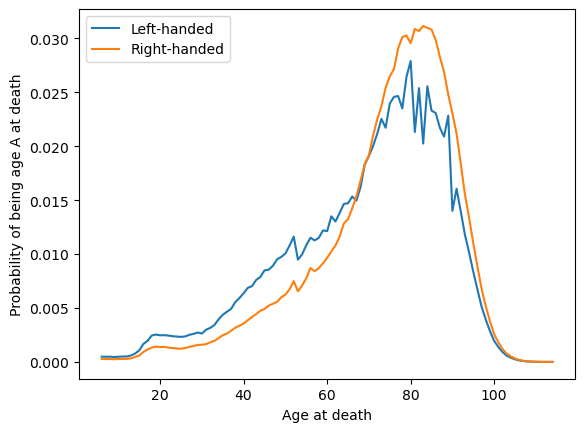

In [34]:
# make a list of ages of death to plot
ages = np.arange(6, 115, 1) 

# calculate the probability of being left- or right-handed for each 
left_handed_probability = P_A_given_lh(ages, death_distribution_data)
right_handed_probability = P_A_given_rh(ages, death_distribution_data)

# create a plot of the two probabilities vs. age
fig, ax = plt.subplots() 
ax.plot(ages, left_handed_probability, label = 'Left-handed')
ax.plot(ages, right_handed_probability, label = 'Right-handed')
ax.legend() 
ax.set_xlabel("Age at death")
ax.set_ylabel("Probability of being age A at death")

In [35]:
# calculate average ages for left-handed and right-handed groups

# use np.array so that two arrays can be multiplied
average_lh_age =  np.nansum(ages*np.array(left_handed_probability))
average_rh_age =  np.nansum(ages*np.array(right_handed_probability))

# print the average ages for each group
print(round(average_lh_age,1))
print(round(average_rh_age,1))

# print the difference between the average ages
print("The difference in average ages is " + str(round(average_rh_age - average_lh_age, 1)) + " years.")

67.2
72.8
The difference in average ages is 5.5 years.
